In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.signal import savgol_filter
from pykalman import KalmanFilter
from getdata import GetDataset

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
data_orig,target = GetDataset(CreateDataFrame=True).Outputdata()

In [3]:
#Interpolacion para que los datos en x1 sean x distantes
x_data = np.linspace(data_orig[0][0].min(),data_orig[0][0].max(),901)
temp = np.zeros((data_orig.shape[0],901))
for i in range(data_orig.shape[0]):
    temp[i,:] = np.interp(x_data,data_orig[i][0][:],data_orig[i][1][:])

In [4]:
# Creacion de arreglos matriciales 30x30 2 channels
data = np.zeros((temp.shape[0],temp.shape[1],2))
for i in range(data.shape[0]):
    data[i,:,0] = savgol_filter(temp[i,:], window_length=50, polyorder=2)
    data[i,:,1] = np.gradient(savgol_filter(data[i,:,0], window_length=50, polyorder=2))

In [5]:
torch.manual_seed(42)
shuffle_idx = torch.randperm(3090, dtype = torch.long)
data_shuffle = data[shuffle_idx]
target_shuffle = target[shuffle_idx]
shuffle_idx

tensor([2082, 2966, 2862,  ...,  847, 2232, 1707])

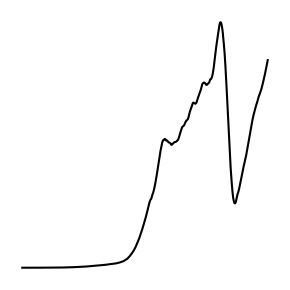

In [9]:
plt.figure(figsize= (3, 3))
plt.plot(x_data, data_shuffle[3089,:,0],  color='k', linewidth=1.5)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.tight_layout()


# Mapeo de los Targets

In [126]:
image_label_map = {}
for idx, label in enumerate(target_shuffle):
    image_label_map[idx] = label


3090

# DataLoader 

In [161]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, root_dir_derivative, image_label_map, transform=None):
        self.root_dir = root_dir
        self.root_dir_derivative = root_dir_derivative
        self.image_label_map = image_label_map
        self.transform = transform

        self.image_files = [file for file in os.listdir(root_dir)]
        self.image_files.sort() 
        self.image_files_derivative = [f"{file.split('.')[0]}_derivada.png" for file in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        img_name_derivative = os.path.join(self.root_dir_derivative, self.image_files_derivative[idx])

        image = Image.open(img_name)
        image_derivative = Image.open(img_name_derivative)

        if self.transform:
            image = self.transform(image)
            image_derivative = self.transform(image_derivative)

        image_combined = torch.cat((image[0:1, :, :], image_derivative[0:1, :, :]), dim=0)

        label = self.image_label_map[int(self.image_files[idx].split('.')[0])]

        label = torch.tensor(label, dtype=torch.float)
        
        filename = int(self.image_files[idx].split('.')[0])

        return image_combined, label, filename

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:2, :, :]), 
    transforms.Normalize((0.5, 0.5), (0.5, 0.5)),  
    transforms.Lambda(lambda x: (x > 0.64).float()) 
])

dataset = CustomImageDataset(
    root_dir='Dataset/img/imagenes',
    root_dir_derivative='Dataset/img/imagenes_derivate',
    image_label_map=image_label_map,
    transform=transform,
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
indices = list(range(len(dataset)))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [163]:
transform2 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:2, :, :]),  # Tomar solo los primeros dos canales
    transforms.Normalize((0.5, 0.5), (0.5, 0.5)),
    transforms.Lambda(lambda x: (x < 0.64).float())  
])

dataset2 = CustomImageDataset(
    root_dir='Dataset/img/imagenes',
    root_dir_derivative='Dataset/img/imagenes_derivate',
    image_label_map=image_label_map,
    transform= transform2,
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
indices = list(range(len(dataset)))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset2 = torch.utils.data.Subset(dataset2, train_indices)
test_dataset2 = torch.utils.data.Subset(dataset2, test_indices)

train_loader2 = DataLoader(train_dataset2, batch_size= 500, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=500, shuffle=False)

In [135]:
image_label_map[988]

3.37

In [136]:
test_dataset.__getitem__(605)


(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor(3.3700),
 988)

## Visualización 


Forma del tensor de imagen: torch.Size([2, 64, 64])
Nombre de la imagen: 988.png 


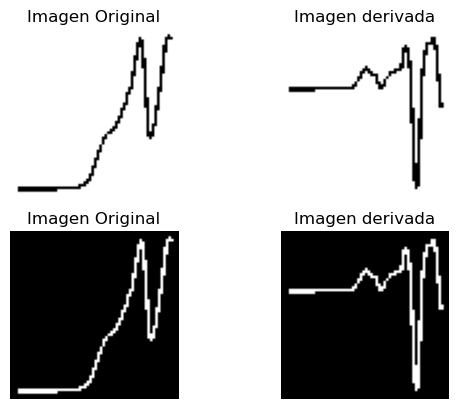

In [123]:
magen,_ , img = test_dataset.__getitem__(605)
magen2, _ , img2 = test_dataset2.__getitem__(605)

print("Forma del tensor de imagen:", magen.shape)

magen_numpy = magen.numpy()
magen2_numpy = magen2.numpy()
print(f'Nombre de la imagen: {img2}.png ')
fig, axs = plt.subplots(2, 2)
axs[0][0].imshow(magen_numpy[0, :, :], cmap='gray')  
axs[0][0].set_title("Imagen Original")
axs[0][0].axis('off')

axs[0][1].imshow(magen_numpy[1, :, :], cmap='gray')  
axs[0][1].set_title("Imagen derivada")
axs[0][1].axis('off')

axs[1][0].imshow(magen2_numpy[0, :, :], cmap='gray')  
axs[1][0].set_title("Imagen Original")
axs[1][0].axis('off')

axs[1][1].imshow(magen2_numpy[1, :, :], cmap='gray')  
axs[1][1].set_title("Imagen derivada")
axs[1][1].axis('off')

plt.show()


# CNN y Entrenamiento

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1) #64x64
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) #32x32
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x
    
def train(modelo, train_loader, criterion, optimizer, epochs, lr):
        
        optimizer = optimizer(modelo.parameters(), lr=lr)
        losses = []
        for epoch in range(epochs):
            running_loss = 0.0
            for i, (inputs, labels, _ ) in enumerate(train_loader, 0):
                # Mover los datos a CUDA
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1).float())

                # Backward pass y optimización
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            losses.append(epoch_loss)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}')
        return losses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

model = CNN()

model.to(device)
loss = train(model, train_loader2, nn.MSELoss(), optim.SGD, epochs= 50, lr=0.001)


Epoch [1/50], Loss: 6.894876289367676
Epoch [2/50], Loss: 4.395724678039551
Epoch [3/50], Loss: 1.8495326519012452
Epoch [4/50], Loss: 0.6592052698135376
Epoch [5/50], Loss: 0.4915377378463745
Epoch [6/50], Loss: 0.47681139707565307
Epoch [7/50], Loss: 0.47016398310661317
Epoch [8/50], Loss: 0.46417367458343506
Epoch [9/50], Loss: 0.4584510803222656
Epoch [10/50], Loss: 0.4529391825199127
Epoch [11/50], Loss: 0.44761861562728883
Epoch [12/50], Loss: 0.44243093132972716
Epoch [13/50], Loss: 0.43734262585639955
Epoch [14/50], Loss: 0.4323891520500183
Epoch [15/50], Loss: 0.4276489675045013
Epoch [16/50], Loss: 0.4231129586696625
Epoch [17/50], Loss: 0.4187521278858185
Epoch [18/50], Loss: 0.4145132124423981
Epoch [19/50], Loss: 0.41039350628852844
Epoch [20/50], Loss: 0.40640961527824404
Epoch [21/50], Loss: 0.40253137350082396
Epoch [22/50], Loss: 0.39880581498146056
Epoch [23/50], Loss: 0.39525089263916013
Epoch [24/50], Loss: 0.391833508014679
Epoch [25/50], Loss: 0.38853907585144043


In [ ]:
modelo2 = CNN()
modelo2.to(device)
loss2 = train(modelo2, train_loader, nn.MSELoss(), optim.SGD, epochs= 50, lr=0.001)

## Prueba con el Test 

Predicción de Bandgap para el 802: 2.6819427013397217
BandGap original:  3.36
BandGap :  802


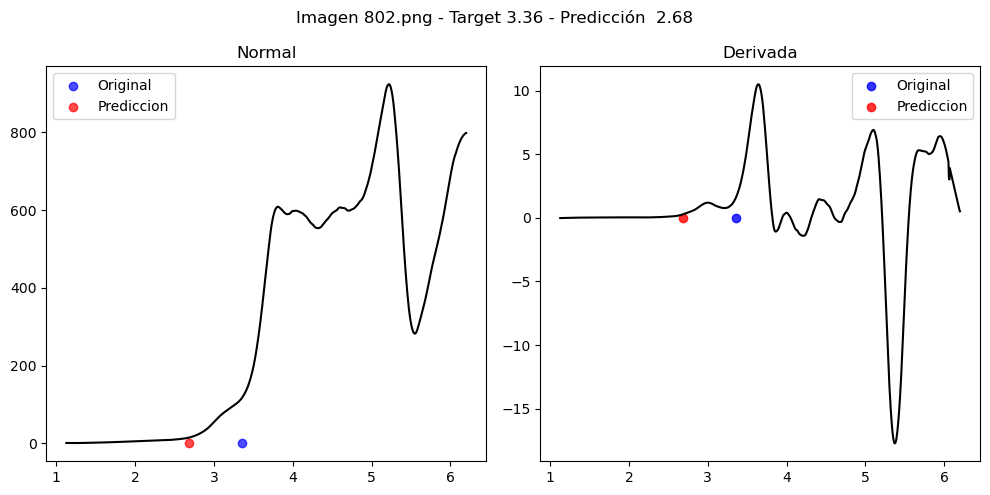

In [157]:
image, label, di = test_dataset2.__getitem__(400)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

model = model.to(device)
model.eval()  
with torch.no_grad():
    outputs = model(image)

predicted_bandgap = outputs.mean().item()

print(f"Predicción de Bandgap para el {di}:", predicted_bandgap)
print('BandGap original: ', target_shuffle[di])
print('BandGap : ', di)

ID = di
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x_data, data_shuffle[ID, :, 0], color='k')
axs[0].scatter(target_shuffle[ID], 0, color='blue', label=f'Original', alpha=0.7)
axs[0].scatter(predicted_bandgap, 0, color='red',  label=f'Prediccion', alpha=0.7)
axs[0].set_title('Normal')

axs[1].plot(x_data, data_shuffle[ID, :, 1], color='k')
axs[1].scatter(target_shuffle[ID], 0, color='blue', label=f'Original', alpha=0.8)
axs[1].scatter(predicted_bandgap, 0, color='red', label=f'Prediccion', alpha=0.8)
axs[1].set_title('Derivada')



axs[0].legend()
axs[1].legend()

fig.suptitle(f'Imagen {di}.png - Target {target_shuffle[ID]} - Predicción  {predicted_bandgap:.2f}')
plt.tight_layout()
plt.show()



In [158]:
image_label_map[di]

3.36

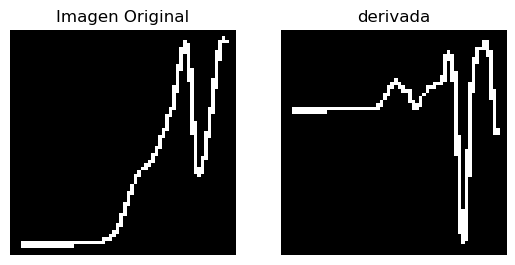

In [145]:
image_cpu = image.cpu()  
photo = image_cpu.numpy()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(photo[0, :, :], cmap='gray')  
axs[0].set_title("Imagen Original")
axs[0].axis('off')

axs[1].imshow(photo[1, :, :], cmap='gray')  
axs[1].set_title("derivada")
axs[1].axis('off')

plt.show()


# Metricas

In [141]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_regression_metrics(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs = inputs.to(device)  # Mover datos a la GPU
            outputs = model(inputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calcular las métricas de regresión
    mae = mean_absolute_error(true_labels, predicted_labels)
    mse = mean_squared_error(true_labels, predicted_labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, predicted_labels)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R^2 Score:", r2)

    return mae, mse, rmse, r2


In [147]:
mae, mse, rmse, r2 = compute_regression_metrics(model, test_loader2)

Mean Absolute Error (MAE): 0.5863583
Mean Squared Error (MSE): 0.4238454
Root Mean Squared Error (RMSE): 0.6510341
R^2 Score: -0.0019578248836527035
